In [5]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split

In [107]:
class Node():
    def __init__(self, Node_L=None, Node_R=None, pred=None, param=None, value=None):
        self.Node_L = Node_L
        self.Node_R = Node_R
        self.pred = pred
        self.param = param
        self.value = value
        

def gini(X):
    targets = X['Target'].unique()
    info = 0
    for target in targets:
        pk = len(X[X['Target'] == target])/len(X)
        info += (pk*(1-pk))
    return info

def entropy(X):
    targets = X['Target'].unique()
    info = 0
    for target in targets:
        pk = len(X[X['Target'] == target])/len(X)
        info += (pk*math.log(pk))
    return -info

class TreeClassifier:        
    def __init__(self, max_depth=None, min_leaf=1, metric=gini):
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.metric = metric
        self.Tree = None

    def class_pred(self, X):
        count_val = X['Target'].value_counts().to_dict()
        # print(count_val, max(count_val, key=count_val.get))
        return max(count_val, key=count_val.get)
        
    def branching(self, params, X, level):
        if (((self.max_depth == -1) or (level < self.max_depth)) and len(X) > self.min_leaf):
            param_choiced = np.random.choice(a=params, size=1)[0]
            # Сортировка данных
            X_sorted = X.sort_values(by=param_choiced)
            
            # Инициализация подсчета
            optimal = -1
            best_split_idx = -1
            target_counts_left = {}
            target_counts_right = dict(X_sorted['Target'].value_counts())
            base_metric = self.metric(X)
            
            for i in range(len(X_sorted) - 1):
                target_val = X_sorted.iloc[i]['Target']
                if target_val in target_counts_left:
                    target_counts_left[target_val] += 1
                else:
                    target_counts_left[target_val] = 1

                target_counts_right[target_val] -= 1

                # Вычисление прироста информации для текущего разделения
                g = self.calculate_gain(target_counts_left, target_counts_right, i+1, len(X_sorted), base_metric)

                # Обновление оптимального разделения
                if g > optimal:
                    optimal = g
                    best_split_idx = i
            # print(best_split_idx, len(X_sorted.iloc[:best_split_idx + 1]), len(X_sorted.iloc[best_split_idx + 1:]))
            if best_split_idx != -1:
                X_l_op = X_sorted.iloc[:best_split_idx + 1]
                X_r_op = X_sorted.iloc[best_split_idx + 1:]
                X_l_Node = self.branching(params, X_l_op, level+1)
                X_r_Node = self.branching(params, X_r_op, level+1)
            else:
                 X_l_Node = self.branching(params, X.take([0]), level+1)
                 X_r_Node = self.branching(params, X.iloc[1:], level+1)
            return Node(Node_L=X_l_Node, Node_R=X_r_Node, param=param_choiced, value=X_sorted.iloc[best_split_idx][param_choiced])
        else:
            return Node(pred=self.class_pred(X))

    def calculate_gain(self, target_counts_left, target_counts_right, left_count, total_count, base_metric):
        # Вычисление прироста информации для текущего разделения
        left_gini = self.calculate_gini(target_counts_left, left_count)
        right_gini = self.calculate_gini(target_counts_right, total_count - left_count)
        g =  base_metric - (left_count / total_count) * left_gini - ((total_count - left_count) / total_count) * right_gini
        return g

    def calculate_gini(self, target_counts, total_count):
        # Вычисление критерия неопределенности для текущего узла
        gini = 0
        for target, count in target_counts.items():
            pk = count / total_count
            gini += (pk * (1 - pk))
        return gini
    
    def fit(self, X:pd.DataFrame, y, metric=gini):
        self.metric = metric
        params = X.columns
        X_m = X*1
        X_m['Target'] = y
        if (self.max_depth == None) or (self.max_depth <= 0):
            self.max_depth = -1
        level = 0
        self.Tree = self.branching(params, X_m, level)
        return self.Tree
    
    def predict(self, X):
        pred = list() 
        for obj in range(len(X)):
            node = self.Tree
            while (node.pred == None):
                if X.iloc[obj][node.param] < node.value:
                    node = node.Node_L
                else:
                    node = node.Node_R
            pred.append(node.pred)
        return pred

In [100]:
np.random.seed(41) # 41
data = pd.read_csv('train.csv')
x = data[['CreditScore', 'Age', 'Tenure']]
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, shuffle = True)
Tree_class = TreeClassifier(max_depth = 10)
Tree_class.fit(X_train, y_train)

{0: 8, 1: 6} 0
{0: 16, 1: 4} 0
{0: 10} 0
{1: 1} 1
{1: 1} 1
{1: 1} 1
{0: 261, 1: 45} 0
{0: 3, 1: 2} 0
{0: 1} 0
{0: 15} 0
{1: 1, 0: 1} 1
{1: 2} 1
{0: 2, 1: 1} 0
{0: 3} 0
{0: 5, 1: 3} 0
{0: 7} 0
{1: 1} 1
{0: 1} 0
{0: 1} 0
{0: 6} 0
{1: 1} 1
{1: 2} 1
{0: 11, 1: 1} 0
{1: 3, 0: 3} 1
{1: 1} 1
{1: 1} 1
{1: 17, 0: 15} 1
{1: 2} 1
{1: 1} 1
{0: 25, 1: 6} 0
{0: 99, 1: 6} 0
{1: 1} 1
{0: 1} 0
{0: 2, 1: 1} 0
{1: 2} 1
{0: 1} 0
{0: 1} 0
{1: 1} 1
{0: 1} 0
{0: 1} 0
{0: 1} 0
{0: 20} 0
{1: 1} 1
{0: 1} 0
{0: 1} 0
{0: 8} 0
{1: 1} 1
{0: 1} 0
{0: 4} 0
{1: 1} 1
{0: 1} 0
{1: 1} 1
{1: 3} 1
{0: 8, 1: 1} 0
{1: 6, 0: 2} 1
{0: 14, 1: 1} 0
{0: 13, 1: 3} 0
{1: 1} 1
{1: 1} 1
{1: 1} 1
{0: 38, 1: 5} 0
{0: 12, 1: 11} 0
{0: 280, 1: 19} 0
{0: 98, 1: 24} 0
{0: 314, 1: 43} 0
{0: 18, 1: 12} 0
{0: 24, 1: 12} 0
{0: 67, 1: 13} 0
{0: 5, 1: 1} 0
{0: 56, 1: 1} 0
{0: 19, 1: 6} 0
{0: 4} 0
{1: 1} 1
{1: 3} 1
{1: 1} 1
{0: 101, 1: 32} 0
{1: 1} 1
{1: 1} 1
{0: 1} 0
{0: 1} 0
{0: 1} 0
{1: 1} 1
{1: 1} 1
{0: 1} 0
{0: 1} 0
{1: 1} 1
{0: 22, 1: 3} 0


In [101]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
DisTree = DecisionTreeClassifier(max_depth = 10)
DisTree.fit(X_train, y_train)
pred_dis = DisTree.predict(X_test)
pred = Tree_class.predict(X_test)

In [84]:
Tree_class.Tree

In [102]:
print(f1_score(y_test, pred), f1_score(y_test, pred_dis))

0.45862012899029864 0.4265924698081932


In [99]:
y_test[:5], pred_dis[:5], y_test[:5], pred[:5]

(23763     0
 135556    0
 118588    0
 59038     1
 101703    0
 Name: Exited, dtype: int64,
 array([0, 0, 0, 0, 0], dtype=int64),
 23763     0
 135556    0
 118588    0
 59038     1
 101703    0
 Name: Exited, dtype: int64,
 [0, 0, 1, 1, 0])

Объем выборки 1000: F1 score моего дерева: 0.3816793893129771, F1 score sklearn дерева: 0.4426229508196721
Объем выборки 9633: F1 score моего дерева: 0.4289911851126347, F1 score sklearn дерева: 0.35714285714285715
Объем выборки 18266: F1 score моего дерева: 0.41935483870967744, F1 score sklearn дерева: 0.36713286713286714
Объем выборки 26900: F1 score моего дерева: 0.4149519890260631, F1 score sklearn дерева: 0.420824295010846
Объем выборки 35533: F1 score моего дерева: 0.4452537023549405, F1 score sklearn дерева: 0.4056578596210302
Объем выборки 44166: F1 score моего дерева: 0.40512273212379935, F1 score sklearn дерева: 0.38244081820271203
Объем выборки 52800: F1 score моего дерева: 0.43804125334592975, F1 score sklearn дерева: 0.42165770443167067
Объем выборки 61433: F1 score моего дерева: 0.3657142857142857, F1 score sklearn дерева: 0.40838709677419355
Объем выборки 70066: F1 score моего дерева: 0.41017754788200755, F1 score sklearn дерева: 0.39716722069663246
Объем выборки 78700: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

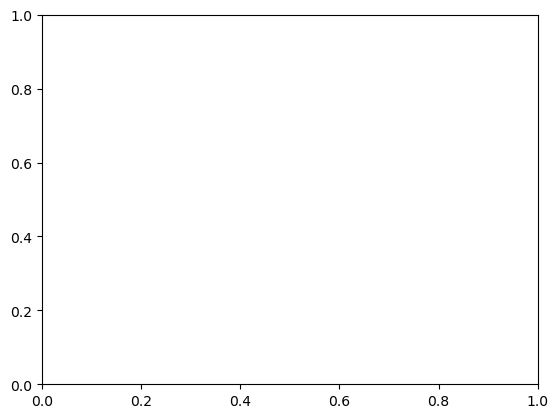

In [116]:
import time
import matplotlib.pyplot as plt
sample_curve_my_tree = []
sample_curve_sk_tree = []
time_curve = []
data = pd.read_csv('train.csv')
for i in np.linspace(1000, len(data), 20):
    np.random.seed(48)
    data1 = data[:int(i)]
    x = data1[['CreditScore', 'Age', 'Tenure']]
    y = data1['Exited']
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, shuffle = True)
    Tree_class = TreeClassifier(max_depth = 10)
    start = time.time()
    Tree_class.fit(X_train, y_train)
    end = time.time() - start
    time_curve.append(end)
    DisTree = DecisionTreeClassifier(max_depth = 10)
    DisTree.fit(X_train, y_train)
    pred_dis = DisTree.predict(X_test)
    pred = Tree_class.predict(X_test)
    sample_curve_my_tree.append(f1_score(y_test, pred))
    sample_curve_sk_tree.append(f1_score(y_test, pred_dis))
    print(f"Объем выборки {int(i)}: F1 score моего дерева: {sample_curve_my_tree[-1]}, F1 score sklearn дерева: {sample_curve_sk_tree[-1]}")

Text(0.5, 1.0, 'Кривая зависимости времени обучения от объёма выборки')

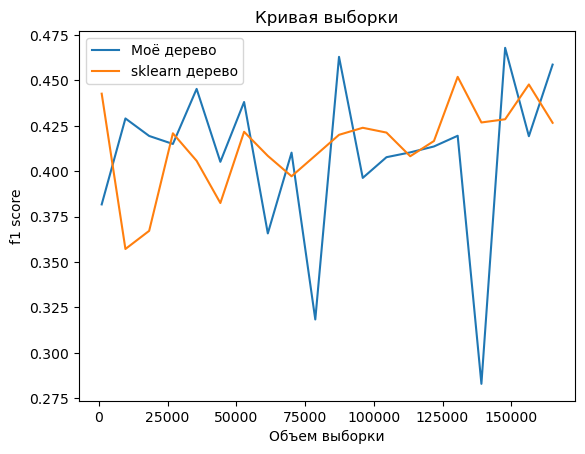

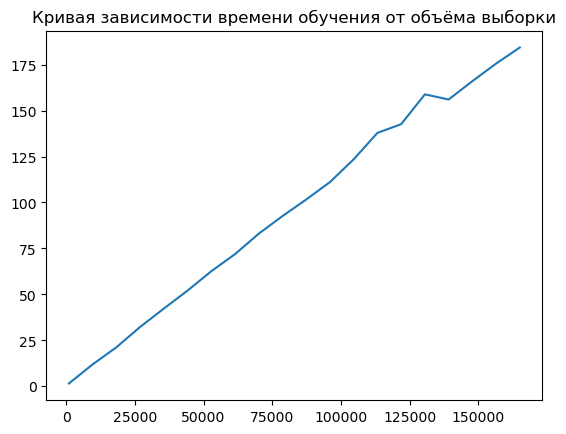

In [117]:
plt.figure(0)
plt.plot(np.linspace(1000, len(data), 20), sample_curve_my_tree)
plt.plot(np.linspace(1000, len(data), 20), sample_curve_sk_tree)
plt.title("Кривая выборки")
plt.legend(["Моё дерево", "sklearn дерево"])
plt.xlabel("Объем выборки")
plt.ylabel("f1 score")
plt.figure(1)
plt.plot(np.linspace(1000, len(data), 20), time_curve)
plt.title("Кривая зависимости времени обучения от объёма выборки")